In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from utilities import lag_matrix
from torch.utils.tensorboard import SummaryWriter
from anarx import ANARX

In [2]:
writer = SummaryWriter()

In [3]:
a = ANARX(10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(a.parameters())



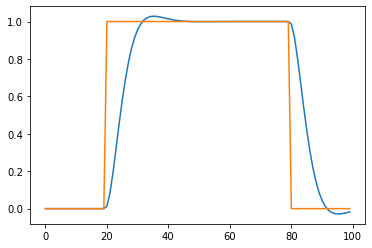

In [12]:
import control
T = 0.01
D = 1.5
sys = control.tf([1], [T**2, D*T, 1])
sys2 = control.tf([1], [1])
time = np.linspace(0, .3, 100)
u = np.concatenate((np.zeros(20), np.ones(60), np.zeros(20)))
_, yout = control.forced_response(sys, T = time, U = u)
_, uin = control.forced_response(sys2, T = time, U = u )
plt.plot(yout)
plt.plot(uin)

In [13]:
inputs = torch.from_numpy(uin)
outputs = torch.from_numpy(yout)
lagged_inputs = lag_matrix(inputs, 3)
i = lagged_inputs[5]


In [14]:
from tqdm import tqdm
for epoch in tqdm(range(1000)):
    y_hat = torch.zeros_like(inputs)
    optimizer.zero_grad()
    lags = a.initLags()
    # Predict whole Dataset
    for i in range(len(inputs)):
        y_hat[i] = a(lagged_inputs[i], lags)
        lags = torch.roll(lags, 1, 0)
        lags[0] = y_hat[i]
    # Compute Loss and optimize
    loss = criterion(y_hat, outputs)
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    # plt.plot(y_hat.detach().numpy())
    # plt.plot(outputs)
    # plt.show()
    # print(loss)
    optimizer.step()

100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


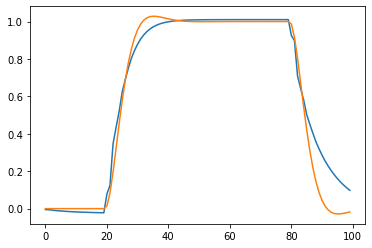

tensor(0.0066, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [15]:
plt.plot(y_hat.detach().numpy())
plt.plot(outputs)
plt.show()
print(loss)

In [16]:
torch.save(a, "anarxpt2.pt")